In [1]:
!pip install joypy
!pip install kaleido

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from joypy import joyplot
from scipy.stats import ttest_ind
import numpy as np
from scipy.stats import chi2_contingency
import plotly.graph_objects as go

In [3]:
df = pd.read_csv("youtube_watch_history.csv")

In [4]:
df["timeWatched"] = pd.to_datetime(df["timeWatched"], errors="coerce")
df["publishedAt"] = pd.to_datetime(df["publishedAt"], errors="coerce")
df["duration"] = pd.to_timedelta(df["duration"])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4094 entries, 0 to 4093
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype                    
---  ------                --------------  -----                    
 0   videoURL              4094 non-null   object                   
 1   title                 4094 non-null   object                   
 2   channelName           4094 non-null   object                   
 3   channelURL            4094 non-null   object                   
 4   timeWatched           4094 non-null   datetime64[ns, UTC+03:00]
 5   videoId               4094 non-null   object                   
 6   kind                  4094 non-null   object                   
 7   publishedAt           4094 non-null   datetime64[ns, UTC]      
 8   tags                  1998 non-null   object                   
 9   categoryId            4094 non-null   int64                    
 10  defaultAudioLanguage  2430 non-null   object                

In [6]:
sns.set_style("whitegrid", {"grid.linestyle": "--"})

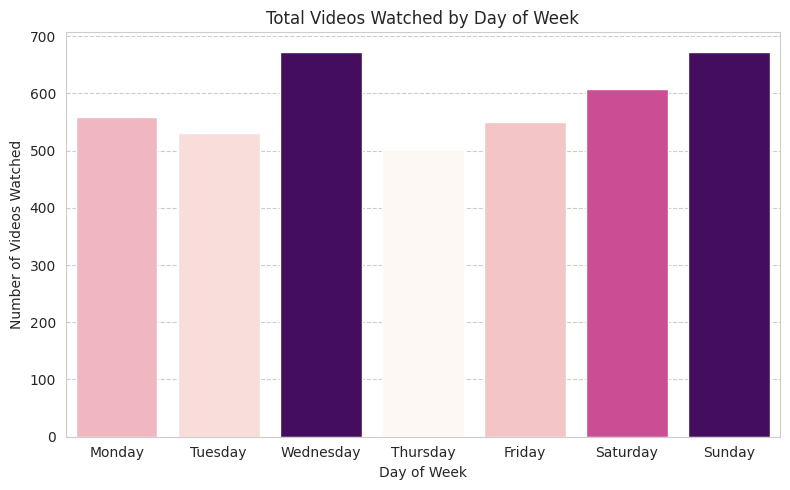

In [7]:
df["dayOfWeek"] = df["timeWatched"].dt.day_name()
df["dayOfWeek"] = pd.Categorical(df["dayOfWeek"], categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)
videos_by_day = df["dayOfWeek"].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=videos_by_day.index, y=videos_by_day.values, hue=videos_by_day.values, palette="RdPu", legend=False)

plt.title("Total Videos Watched by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Videos Watched")
plt.tight_layout()
plt.savefig("DOWBarPlot.png", dpi=600, bbox_inches="tight")
plt.show()

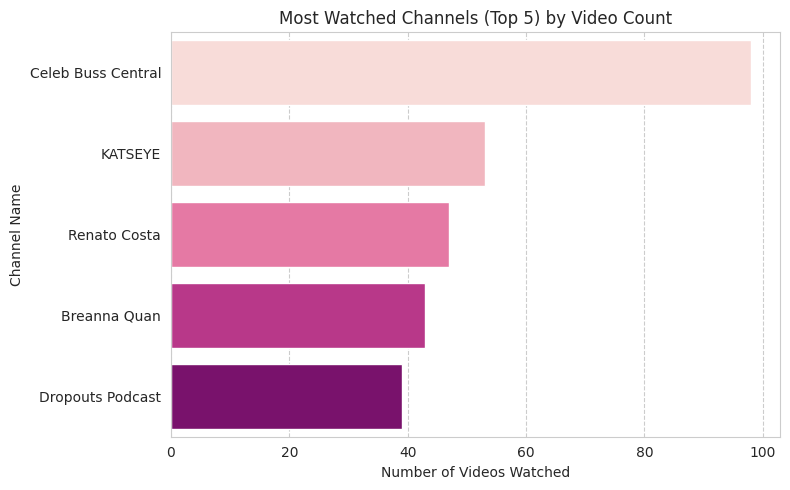

In [8]:
channel_counts = df[~df["tags"].str.contains("shorts", na=False)].groupby("channelName")["videoId"].count().sort_values(ascending=False).head(5)

plt.figure(figsize=(8, 5))
sns.barplot(x=channel_counts.values, y=channel_counts.index, hue=channel_counts.index, palette="RdPu", legend=False)

plt.title("Most Watched Channels (Top 5) by Video Count")
plt.xlabel("Number of Videos Watched")
plt.ylabel("Channel Name")
plt.tight_layout()
plt.savefig("ChannelBarPlot.png", dpi=600, bbox_inches="tight")
plt.show()

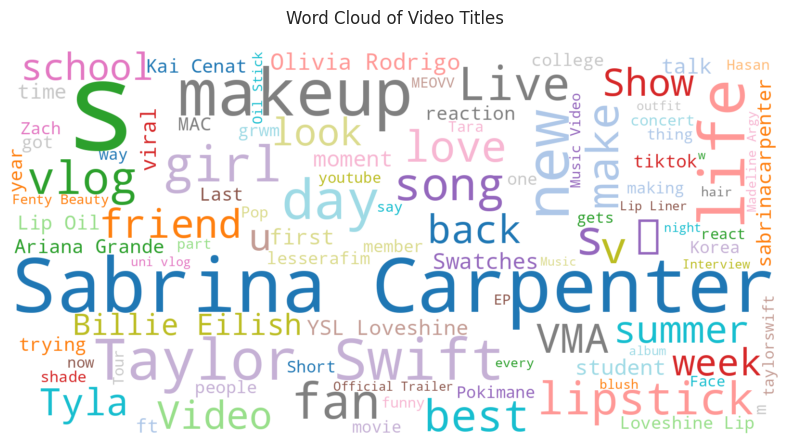

In [9]:
all_titles = " ".join(df["title"].tolist())

wordcloud = WordCloud(
    width=1600, height=800,
    background_color="white",
    colormap="tab20",
    max_words=100
).generate(all_titles)

plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Video Titles", pad=20)
plt.tight_layout()
plt.savefig("Wordcloud.png", dpi=600, bbox_inches="tight")
plt.show()

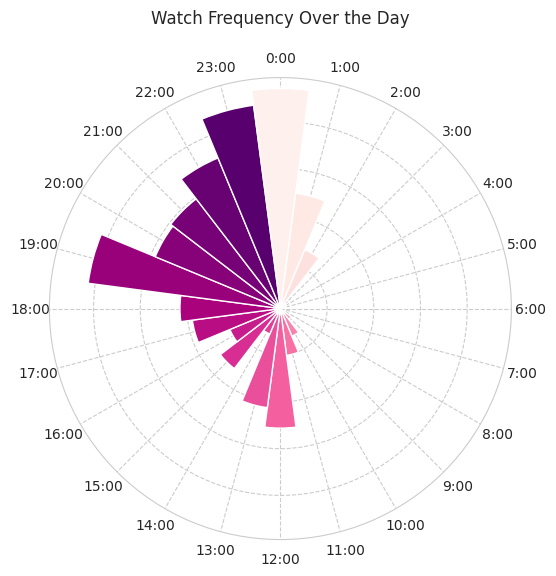

In [10]:
counts_by_hour = df["timeWatched"].dt.hour.value_counts().sort_index()
hours = np.arange(24)
values = [counts_by_hour.get(h, 0) for h in hours]
angles = np.linspace(0, 2 * np.pi, 24, endpoint=False)
values += [values[0]]
angles = np.concatenate((angles, [angles[0]]))

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={"projection": "polar"})

bar_width = 2 * np.pi / 24
bars = ax.bar(
    angles,
    values,
    width=bar_width,
    color=sns.color_palette("RdPu", 24),
    edgecolor="white"
)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

hour_labels = [f"{h}:00" for h in hours]
ax.set_thetagrids(np.degrees(angles[:-1]), hour_labels)

ax.set_yticklabels([])
plt.title("Watch Frequency Over the Day", y=1.1)
plt.savefig("PolarChart.png", dpi=600, bbox_inches="tight")
plt.show()

In [11]:
def format_hour(hour):
    if hour == 0:
        return "12 AM"
    elif hour < 12:
        return f"{hour} AM"
    elif hour == 12:
        return "12 PM"
    else:
        return f"{hour % 12} PM"

df["hour"] = df["timeWatched"].dt.hour.apply(format_hour)
df["hour"] = pd.Categorical(df["hour"], categories=["12 AM", "11 PM", "10 PM", "9 PM", "8 PM", "7 PM", "6 PM", "5 PM", "4 PM", "3 PM", "2 PM", "1 PM", "12 PM", "11 AM", "10 AM", "9 AM", "8 AM", "7 AM", "6 AM", "5 AM", "4 AM", "3 AM", "2 AM", "1 AM"], ordered=True)

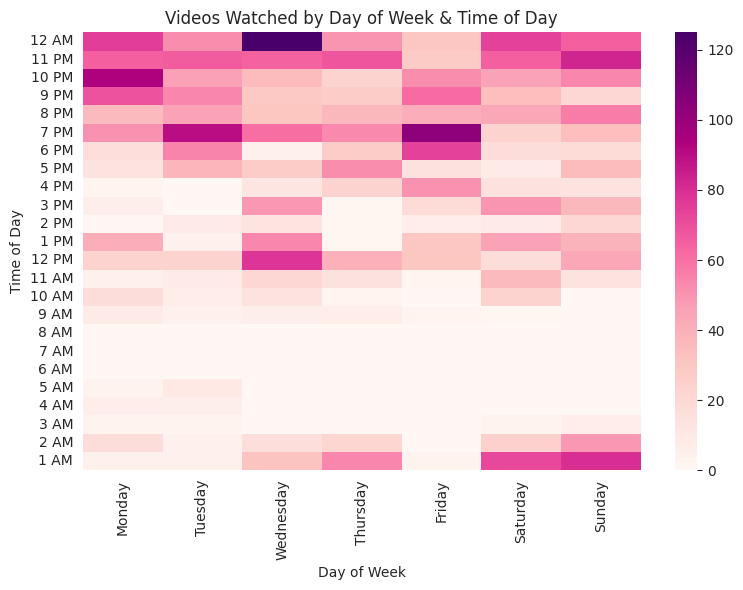

In [12]:
videos_by_day_time = df.groupby(["dayOfWeek", "hour"], observed=False).size().reset_index(name="counts")

pivot_table = videos_by_day_time.pivot(index="hour", columns="dayOfWeek", values="counts").fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, cmap="RdPu", linewidths=0)

plt.title("Videos Watched by Day of Week & Time of Day")
plt.xlabel("Day of Week")
plt.ylabel("Time of Day")
plt.tight_layout()
plt.savefig("Heatmap.png", dpi=600, bbox_inches="tight")
plt.show()

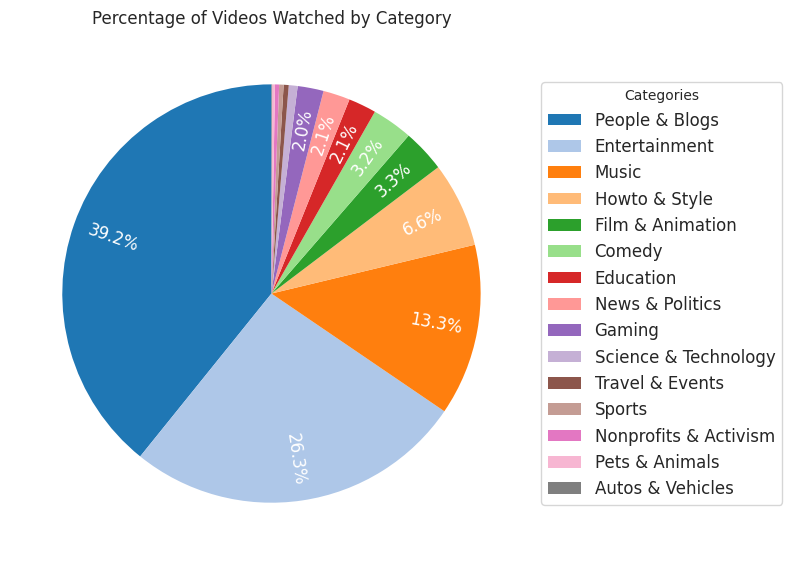

In [13]:
category_counts = df["categoryName"].value_counts()

def autopct_threshold(pct):
    return f"{pct:.1f}%" if pct >= 2 else ""

colors = sns.color_palette("tab20", len(category_counts))

fig, ax = plt.subplots(figsize=(8, 8))

wedges, texts, autotexts = ax.pie(
    category_counts,
    labels=None,
    autopct=autopct_threshold,
    pctdistance=0.8,
    startangle=90,
    colors=colors,
    wedgeprops={"linewidth": 0}
)

for i, autotext in enumerate(autotexts):
    angle = (wedges[i].theta2 + wedges[i].theta1) / 2
    x, y = autotext.get_position()
    rotation = angle

    if 90 < angle <= 270:
        rotation += 180

    autotext.set_rotation(rotation)
    autotext.set_verticalalignment("center")
    autotext.set_horizontalalignment("center")
    autotext.set_fontsize(12)
    autotext.set_color("white")

ax.legend(
    labels=category_counts.index,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title="Categories",
    fontsize=12
)

plt.title("Percentage of Videos Watched by Category")
plt.tight_layout()
plt.savefig("PieChart.png", dpi=600, bbox_inches="tight")
plt.show()

In [14]:
df["duration"] = pd.to_numeric(df["duration"], errors="coerce").fillna(0)

avg_duration = df["duration"].mean() / (1e9 * 60)
max_duration = df["duration"].max() / (1e9 * 60)

total_videos = len(df)
unique_videos = df["videoId"].nunique()

earliest_day = df["timeWatched"].min().normalize()
latest_day = df["timeWatched"].max().normalize()
num_days = (latest_day - earliest_day).days + 1

videos_per_day = total_videos / num_days

summary_data = {
    "Metric": [
        "Average Video Duration (min)",
        "Max Video Duration (min)",
        "Total Videos Watched",
        "Total Unique Videos Watched",
        "Videos Watched Per Day on Average"
    ],
    "Value": [
        avg_duration,
        max_duration,
        total_videos,
        unique_videos,
        videos_per_day
    ]
}

summary_df = pd.DataFrame(summary_data)

summary_df.set_index("Metric", inplace=True)
summary_df.index.name = None
summary_df.columns.name = None
summary_df = summary_df.round(2)
summary_df

,Value
Average Video Duration (min),5.72
Max Video Duration (min),198.20
Total Videos Watched,4094.00
Total Unique Videos Watched,3940.00
Videos Watched Per Day on Average,22.25


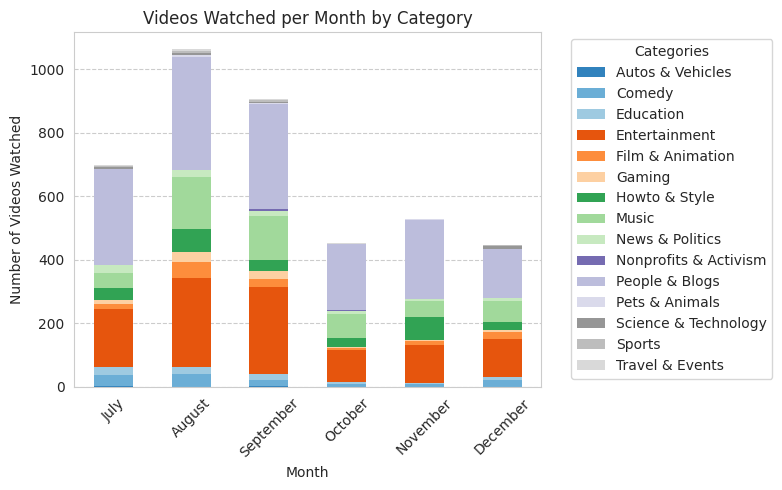

In [15]:
df["month"] = df["timeWatched"].dt.month_name()

videos_by_month_category = df.groupby(["month", "categoryName"]).size().unstack(fill_value=0)

videos_by_month_category = videos_by_month_category.reindex(["July", "August", "September", "October", "November", "December"])

fig, ax = plt.subplots(figsize=(8, 5))
videos_by_month_category.plot(
    kind="bar",
    stacked=True,
    colormap="tab20c",
    ax=ax,
    edgecolor="none"
)

plt.title("Videos Watched per Month by Category")
plt.xlabel("Month")
plt.ylabel("Number of Videos Watched")
plt.xticks(rotation=45)

ax.grid(axis="x", visible=False)
ax.grid(axis="y", linestyle="--")

plt.legend(title="Categories", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig("StackedBarChart.png", dpi=600, bbox_inches="tight")
plt.show()

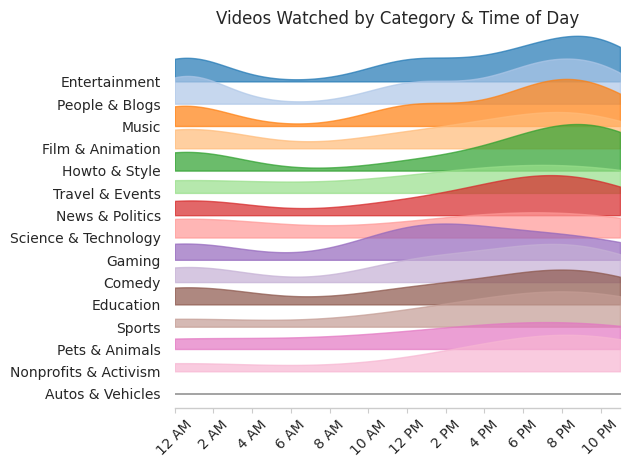

In [16]:
category_hours = [df[df["categoryName"] == category]["timeWatched"].dt.hour.values for category in df["categoryName"].unique()]

category_labels = [category for category in df["categoryName"].unique()]

color_list = sns.color_palette("tab20", len(category_labels))

fig, axes = joyplot(
    data=category_hours,
    labels=category_labels,
    title="Videos Watched by Category & Time of Day",
    x_range=(0, 23),
    color=color_list,
    fill=True,
    alpha=0.7
)

for ax in axes:
    for line in ax.lines:
        line.set_visible(False)

hours = range(0, 24, 2)
hour_labels = [f"{h % 12 or 12} {'AM' if h < 12 else 'PM'}" for h in hours]

ax = plt.gca()
ax.spines["bottom"].set_visible(True)
ax.spines["bottom"].set_linewidth(1)
ax.spines["bottom"].set_position(("data", 0.07))

plt.tick_params(axis="x", which="both", bottom=True)
ax.set_xticks(hours, hour_labels, rotation=45)
ax.tick_params(axis="x", color=(0.8, 0.8, 0.8, 1.0))

plt.savefig("JoyPlot.png", dpi=600, bbox_inches="tight")
plt.show()

In [17]:
df["duration"] = df["duration"] / (1e9 * 60)

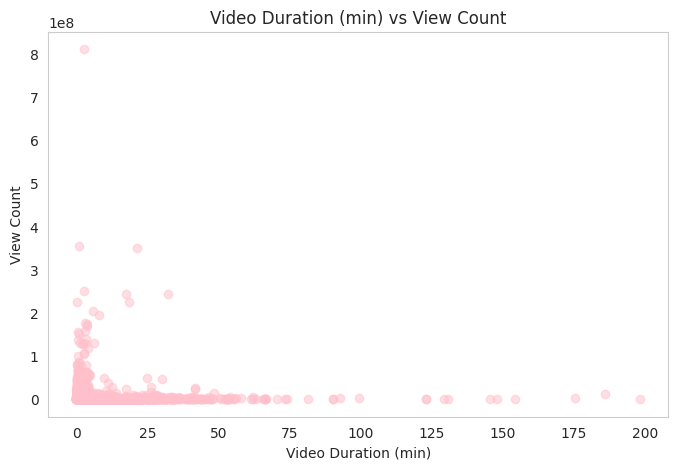

Pearson correlation: -0.026575163817147876


In [18]:
plt.figure(figsize=(8, 5))
sns.regplot(data=df, x="duration", y="viewCount", scatter_kws={"alpha": 0.5, "color": "pink"}, fit_reg=False)

plt.title("Video Duration (min) vs View Count")
plt.xlabel("Video Duration (min)")
plt.ylabel("View Count")
plt.grid(False)
plt.savefig("ScatterPlot.png", dpi=600, bbox_inches="tight")
plt.show()

corr = df[["duration", "viewCount"]].corr().iloc[0,1]
print(f"Pearson correlation: {corr}")

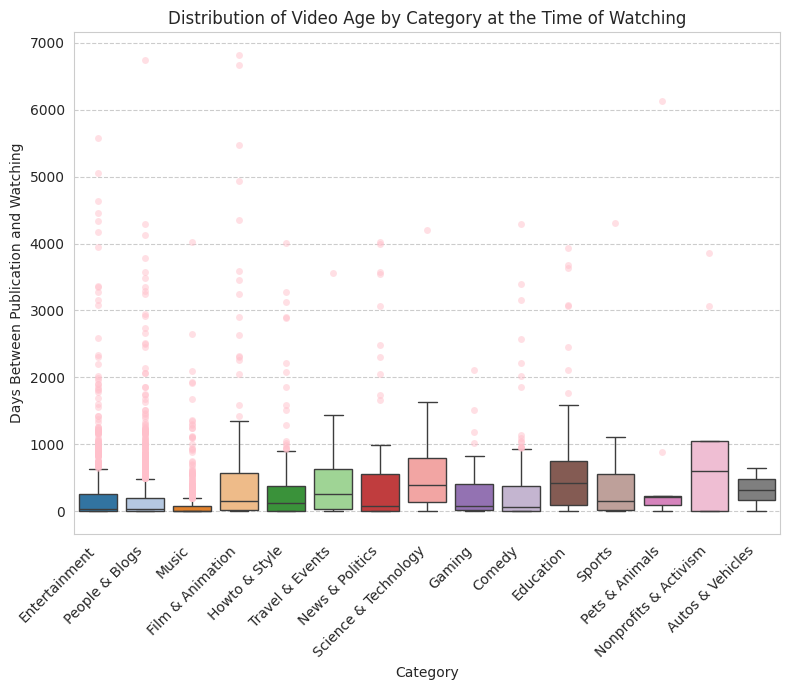

In [19]:
df["DiffWatchingPublication"] = (df["timeWatched"] - df["publishedAt"]).dt.days

palette = sns.color_palette("tab20", len(df["categoryName"].unique()))

plt.figure(figsize=(8, 7))
sns.boxplot(
    data=df,
    x="categoryName",
    y="DiffWatchingPublication",
    hue="categoryName",
    legend=False,
    palette=palette,
    flierprops={"marker": "o", "markerfacecolor": "pink", "markersize": 5, "alpha": 0.5, "markeredgewidth": 0},
)

plt.title("Distribution of Video Age by Category at the Time of Watching")
plt.xlabel("Category")
plt.ylabel("Days Between Publication and Watching")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("BoxPlot.png", dpi=600, bbox_inches="tight")
plt.show()

T-statistic: 2.629, p-value: 0.00863
Reject H0: Video durations differ between weekends and weekdays.


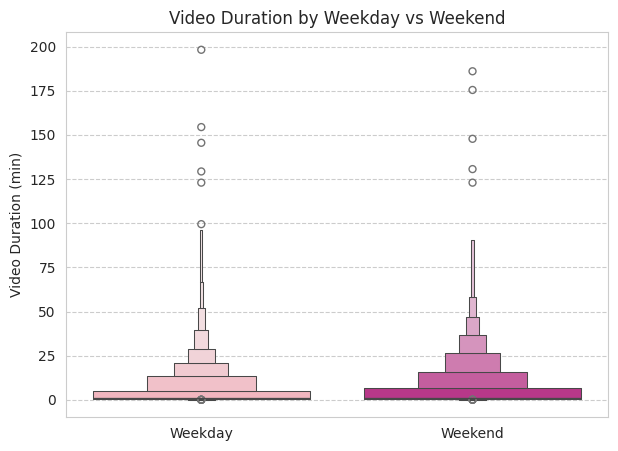

In [20]:
weekend_days = {"Saturday", "Sunday"}

df["dayType"] = df["dayOfWeek"].apply(lambda x: "Weekend" if x in weekend_days else "Weekday")

weekend_durations = df.loc[df["dayType"] == "Weekend", "duration"]
weekday_durations = df.loc[df["dayType"] == "Weekday", "duration"]

t_stat, p_val = ttest_ind(weekend_durations, weekday_durations, equal_var=False, nan_policy="omit")
print(f"T-statistic: {t_stat:.3f}, p-value: {p_val:.3g}")
if p_val < 0.05:
    print("Reject H0: Video durations differ between weekends and weekdays.")
else:
    print("Fail to Reject H0: No evidence of a significant difference.")

plt.figure(figsize=(7, 5))
ax = sns.boxenplot(data=df, x="dayType", y="duration", hue="dayType", legend=False, palette="RdPu")

plt.title("Video Duration by Weekday vs Weekend")
plt.xlabel("")
plt.ylabel("Video Duration (min)")
plt.savefig("BoxenPlot.png", dpi=600, bbox_inches="tight")
plt.show()

In [21]:
def time_segment(hour):
    if 6 <= hour <= 12:
        return "Morning"
    elif hour >= 20 or hour < 3:
        return "Night"
    else:
        return "Other"

df["timeSegment"] = df["timeWatched"].dt.hour.apply(time_segment)

df["tags"] = df["tags"].fillna("").apply(lambda x: x.split(","))
df_exploded = df.explode("tags")
df_exploded["tags"] = df_exploded["tags"].str.strip().replace("", np.nan)
df_exploded.dropna(subset=["tags"], inplace=True)

df_morning_night = df_exploded[df_exploded["timeSegment"].isin(["Morning", "Night"])]
contingency = pd.crosstab(df_morning_night["timeSegment"], df_morning_night["tags"])

chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi2-statistic: {chi2:.3f}, p-value: {p:.3g}")
if p < 0.05:
    print("Reject H0: Distribution of tags differs between morning and night.")
else:
    print("Fail to Reject H0: No significant difference in tag distribution.")

top_tags = df_morning_night["tags"].value_counts().head(10).index
df_sankey = df_morning_night[df_morning_night["tags"].isin(top_tags)]

segments = df_sankey["timeSegment"].unique().tolist()
tags = top_tags.tolist()

segment_nodes = {seg: i for i, seg in enumerate(segments)}
tag_nodes = {tag: i + len(segment_nodes) for i, tag in enumerate(tags)}

sources = []
targets = []
values = []
for seg in segments:
    for tag in tags:
        count = df_sankey[(df_sankey["timeSegment"] == seg) & (df_sankey["tags"] == tag)].shape[0]
        if count > 0:
            sources.append(segment_nodes[seg])
            targets.append(tag_nodes[tag])
            values.append(count)

all_nodes = list(segment_nodes.keys()) + list(tag_nodes.keys())

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        label=all_nodes
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
)])

fig.update_layout(title_text="Frequency of Tags Across Day Segments", font_size=10)
fig.write_image("SankeyDiagram.png", scale=5)
fig.show()

Chi2-statistic: 12140.570, p-value: 1
Fail to Reject H0: No significant difference in tag distribution.


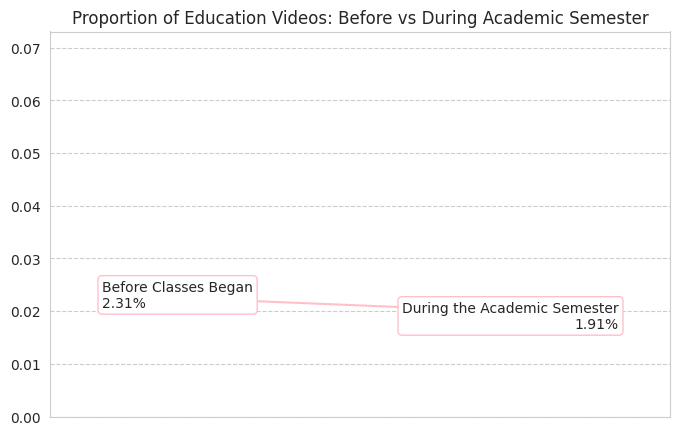

In [22]:
cutoff = pd.to_datetime("2024-09-23").date()
df["period"] = np.where(df["timeWatched"].dt.date < cutoff, "Before Semester", "During Semester")

education_counts = df.groupby("period")["categoryName"].apply(lambda x: (x == "Education").sum()).reset_index(name="educationCount")
total_counts = df.groupby("period").size().reset_index(name="totalCount")
merge_counts = pd.merge(education_counts, total_counts, on="period")
merge_counts["proportionEdu"] = merge_counts["educationCount"] / merge_counts["totalCount"]

before = merge_counts.loc[merge_counts["period"] == "Before Semester", "proportionEdu"].values[0]
after = merge_counts.loc[merge_counts["period"] == "During Semester", "proportionEdu"].values[0]

plt.figure(figsize=(8, 5))
plt.plot([0,1], [before, after], color="pink")

for i, label in enumerate(["Before Classes Began", "During the Academic Semester"]):
    y_val = before if i == 0 else after
    plt.text(i, y_val, f"{label}\n{y_val:.2%}",
             ha="left" if i == 0 else "right",
             va="center",
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="pink"))

plt.xlim(-0.1, 1.1)
plt.ylim(0, max(before, after) + 0.05)
plt.xticks([])
plt.title("Proportion of Education Videos: Before vs During Academic Semester")
plt.savefig("SlopeChart.png", dpi=600, bbox_inches="tight")
plt.show()